<div class="alert alert-info">
    <h2 align="center"> Week 09: Advanced Topics in Artificial Neural Networks</h2>
    <h3 align="center"><a href="http://www.snrazavi.ir">Seyed Naser RAZAVI</a></h3>
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import layers
from data_utils import get_CIFAR10_data
from solver import Solver
from fc_net import FullyConnectedNet


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'spline16'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
np.set_printoptions(formatter={'all': lambda x: "%.2f" % x})

## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the (preprocessed) CIFAR10 data.
cifar10_dir = "../datasets/cifar-10-batches-py/"

data = get_CIFAR10_data(cifar10_dir)
for k, v in data.items():
    print('%-7s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val  :  (1000, 3, 32, 32)
y_val  :  (1000,)
X_test :  (1000, 3, 32, 32)
y_test :  (1000,)


In [4]:
X_train, y_train = data['X_train'], data['y_train']
X_val,   y_val   = data['X_val'  ], data['y_val'  ]
X_test,  y_test  = data['X_test' ], data['y_test' ]

# Non-Linear Classification: Deep Artificial Neural Networks

## Objectives
Today, we will take a look at:
- Deep Neural Networks: more powerfull
- Dropout: another powerfull regularization technique
- Batch Normalization
- Learning rate decay
- Other update rules (momentum, adagrad, RMSProp, Adam)
- Data Augmentation

## Recall: Artificial Neural Networks
**Linear Classifier:**

### $$f = Wx$$

**Two Layer Neural Net:**

### $$f = W_2 \max(0, W_1 x)$$

<img src="http://www.snrazavi.ir/imgs/09-two-layer-NN.jpg" width="50%">

**Three Layer Neural Net:**

### $$f = W_3 \max(0, W_2 \max(0, W_1 x))$$

<img src="http://www.snrazavi.ir/imgs/09-three-layer-NN.jpg" width="50%">

### Recall: Non-linearity (Activation function)
- The non-linear functions in hidden layers are very important.
- Without them, the neural network is nothing more than a linear score function.
- For example, whithout non-linear functions in a 2-hidden layer NN, we would have:

$$f = (W_3 \times W_2 \times W_1) x = W x$$

## Recall: Implementing a 2-Layer Neural Network

- **Input:** $x$
- **Hidden layer:** affine-relu
- **Output layer:** affine (linear)

In [5]:
from layers import *

def two_layer_network_loss(X, y, params):
    W1, b1 = params['W1'], params['b1']    
    W2, b2 = params['W2'], params['b2']
    
    ################
    # forward step #
    ################
    h, cache_h = affine_relu_forward(X, W1, b1)  # hidden layer
    scores, cache_o = affine_forward(h, W2, b2)  # output layer
    
    #####################
    # Compute data loss #
    #####################
    loss, dscores = softmax_loss(scores, y)
       
    #################
    # Backward step #
    #################
    dh, dW2, db2 = affine_backward(dscores, cache_o)  # output layer
    _, dW1, db1 = affine_relu_backward(dh, cache_h)   # hidden layer
       
    grads = {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}
    return loss, grads

In [6]:
def predict(X, params):
    W1, b1 = params['W1'], params['b1']    
    W2, b2 = params['W2'], params['b2']
    
    h, _ = affine_relu_forward(X, W1, b1)  # hidden layer
    scores, _ = affine_forward(h, W2, b2)  # output layer
    
    return np.argmax(scores, axis=1)

In [7]:
def accuracy(y_pred, y_true):
    return 100.0 * np.mean(y_pred == y_true)

# Multi Layer Neural Network

In [8]:
def multi_layer_network_loss(X, y, params):
    num_layers = len(params) // 2
    
    ################
    # forward step #
    ################
    loss = 0.0
    cache, h = {}, X
    
    for i in range(1, num_layers + 1):
        W, b = params['W%d' % i], params['b%d' % i]
        
        if i < num_layers:  # hidden layer
            h, cache[i] = affine_relu_forward(h, W, b)
        else:
            scores, cache[i] = affine_forward(h, W, b)
        
        loss += 0.5 * reg * np.sum(W * W)  # regularization loss
        
    #####################
    # Compute data loss #
    #####################
    data_loss, dscores = softmax_loss(scores, y)
    loss += data_loss
           
    #################
    # Backward step #
    #################
    grads = {}
    for i in reversed(range(1, num_layers + 1)):
        
        if i == num_layers:  # output layer
            dout, dW, db = affine_backward(dscores, cache[i])
        else:  # hidden layer
            dout, dW, db = affine_relu_backward(dout, cache[i])
        
        W = params['W%d' % i]
        grads['W%d' % i] = dW + reg * W
        grads['b%d' % i] = db
                       
    return loss, grads

In [9]:
def predict(X, params):
    h = X
    for i in range(1, num_layers + 1):
        
        W, b = params['W%d' % i], params['b%d' % i]
        if i < num_layers:  # hidden layer
            h, _ = affine_relu_forward(h, W, b)
        else:
            scores, _ = affine_forward(h, W, b)
            
    return np.argmax(scores, axis=1)

## Minimize Loss Function: `Gradient Descent`

#### Define Structure

In [10]:
num_inputs = 3072
num_outputs = 10
hidden_dims = [200, 200, 200, 200]

#### Gradient descent

In [11]:
# Initialize parameters
params = {}
dims = [num_inputs] + hidden_dims + [num_outputs]
num_layers = len(dims) - 1
for i in range(1, num_layers + 1):
    params['W%d' % i] = 0.03 * np.random.randn(dims[i - 1], dims[i])
    params['b%d' % i] = np.zeros(dims[i])

N = X_train.shape[0]

# hyper-parameters
n_iterations = 2000
batch_size = 256

lr = 0.05
reg = 1e-5

loss_history = []
best_params = params.copy()
best_val = 0

# Gradient Descent
for i in range(n_iterations + 1):
    # create a batch of training data
    idx = np.random.choice(N, batch_size, replace=False)
    X_batch, y_batch = X_train[idx], y_train[idx]
    
    loss, grads = multi_layer_network_loss(X_batch, y_batch, params) 
    loss_history.append(loss)
    
    # report every 100 iterations
    if i % 200 == 0:
        y_train_pred = predict(X_batch, params)
        train_acc = accuracy(y_train_pred, y_batch)
        
        y_val_pred = predict(X_val, params)
        val_acc = accuracy(y_val_pred, y_val)
        if val_acc > best_val:
            best_val = val_acc
            best_params = params.copy()
        
        print("%4d: loss = %.2f | train accuracy = %5.2f | validation accuracy = %5.2f" % 
              (i, loss, train_acc, val_acc))
    
    # update parameters
    for p in params:
        params[p] -= lr * grads[p]

   0: loss = 2.77 | train accuracy = 12.11 | validation accuracy =  8.50
 200: loss = 1.68 | train accuracy = 37.89 | validation accuracy = 41.90
 400: loss = 1.27 | train accuracy = 53.52 | validation accuracy = 45.80
 600: loss = 1.44 | train accuracy = 47.66 | validation accuracy = 47.70
 800: loss = 1.26 | train accuracy = 51.56 | validation accuracy = 46.80
1000: loss = 1.05 | train accuracy = 61.33 | validation accuracy = 49.30
1200: loss = 1.11 | train accuracy = 60.55 | validation accuracy = 48.60
1400: loss = 1.10 | train accuracy = 58.98 | validation accuracy = 49.50
1600: loss = 1.03 | train accuracy = 62.11 | validation accuracy = 49.30
1800: loss = 0.86 | train accuracy = 71.09 | validation accuracy = 51.60
2000: loss = 0.94 | train accuracy = 66.80 | validation accuracy = 49.70


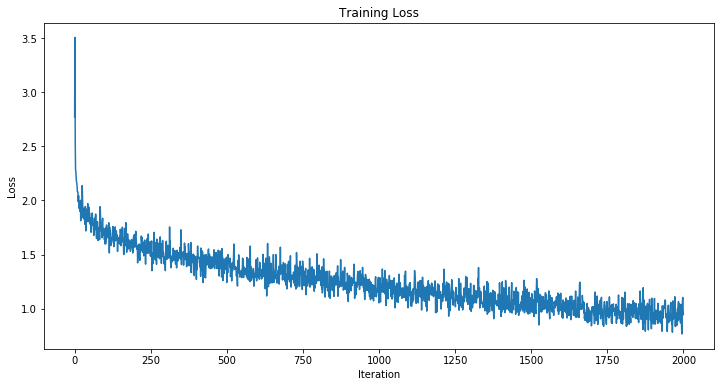

In [12]:
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss');

### Prediction on test data

In [13]:
test_pred = predict(X_test, best_params)
test_accuracy = accuracy(test_pred, y_test)
print("Test accuracy = %.2f" % test_accuracy)

Test accuracy = 49.60


<div class="alert alert-success">
    <h2>How to improve accuracy?</h2>
    <ul>
        <li>Increase <b>size</b> of hidden layers.</li>
        <li>Increase <b>number</b> of hidden layers.</li>
        <li>Do you mean DEEP LEARNING?</li>
    </ul>
</div>

### Problem
- The larger the neural net is, the higher the chance of **overfitting**.
- So, we need other ways of **regularization**.
 - Next week, we will see **Dropout**, which is a recent strong way of regularization.
 - Also, we will take a look at **batch normalization** and **weight initialization**.

For a complete introduction to dropout and batch normalization, please refer to my slides or videos.

# Dropout

<img src ="http://www.snrazavi.ir/imgs/09-Dropout.jpg" width="75%"/>

In [14]:
def dropout_forward(x, p):
    mask = (np.random.rand(*x.shape) < (1 - p)) / (1 - p)
    out = x * mask
    cache = (mask, p)    
    out = out.astype(x.dtype, copy=False)
    return out, cache

def dropout_backward(dout, cache):
    mask, p = cache
    dx = dout * mask
    return dx

In [15]:
x = np.random.rand(10)
print(x)

x_dropout, _ = dropout_forward(x, 0.3)
print(x_dropout)

[0.44 0.37 0.89 0.85 0.14 0.82 0.46 0.79 0.16 0.12]
[0.62 0.52 1.27 0.00 0.19 1.17 0.00 1.12 0.23 0.00]


# Batch Normalization
- **Normalize** the output of each hidden layer.

### $$x^{(k)} = \frac{x^{(k)} - E[x^{(k)}]}{\sqrt{Var[x^{(k)}]}}$$

- **Scale** and **shift** the normalized outputs (if needed).

### $$y^{(k)} = \gamma^{(k)} x^{(k)} + \beta^{(k)}$$

<img src ="http://www.snrazavi.ir/imgs/09_batch_norm.png" width="75%"/>

In [16]:
def batchnorm_forward(x, gamma, beta, bn_param):
    N, D = x.shape

    # get parameters
    mode = bn_param['mode']                   # mode is train or test
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)
    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
    running_var  = bn_param.get('running_var',  np.zeros(D, dtype=x.dtype))
    cache = None

    if mode == 'train':
        
        # Normalize
        mu = np.mean(x, axis=0)
        xc = x - mu
        var = np.mean(xc ** 2, axis=0)
        std = (var + eps) ** 0.5
        xn = xc / std
        
        # Scale and Shift
        out = gamma * xn + beta

        cache = (x, xc, xn, mu, var, std, gamma, eps)

        # update running mean and running average
        running_mean = momentum * running_mean + (1 - momentum) * mu
        running_var  = momentum * running_var  + (1 - momentum) * var
        
        bn_param['running_mean'] = running_mean
        bn_param['running_var' ] = running_var
    
    else:
        xn = (x - running_mean) / (np.sqrt(running_var + eps))
        out = gamma * xn + beta
        
    return out, cache

In [17]:
# Simulate the forward pass for a two-layer network
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print('  mean: ', a.mean(axis=0))
print('   std: ', a.std(axis=0))

# Means should be close to zero and stds close to one
print('\nAfter batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print('  mean: ', a_norm.mean(axis=0))
print('   std: ', a_norm.std(axis=0))

# Now means should be close to beta and stds close to gamma
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print('\nAfter batch normalization (nontrivial gamma, beta)')
print('  means: ', a_norm.mean(axis=0))
print('   stds: ', a_norm.std(axis=0))

Before batch normalization:
  mean:  [-2.38 -13.18 1.92]
   std:  [27.19 34.21 37.69]

After batch normalization (gamma=1, beta=0)
  mean:  [0.00 0.00 0.00]
   std:  [1.00 1.00 1.00]

After batch normalization (nontrivial gamma, beta)
  means:  [11.00 12.00 13.00]
   stds:  [1.00 2.00 3.00]


## Batchnorm for deep networks
Run the following to train a six-layer network on a subset of 1000 training examples both with and without batch normalization.

In [18]:
np.random.seed(231)
# Try training a very deep net with batchnorm
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

bn_solver = Solver(bn_model, small_data,
                   num_epochs=10, batch_size=50,
                   update_rule='adam',
                   optim_config={
                       'learning_rate': 1e-3,
                   },
                   verbose=True, print_every=200)
bn_solver.train()

solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                    'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
solver.train()

(Iteration    1 /  200) loss: 2.340974
(Epoch  0 / 10) train acc: 0.105000; val_acc: 0.111000
(Epoch  1 / 10) train acc: 0.300000; val_acc: 0.244000
(Epoch  2 / 10) train acc: 0.436000; val_acc: 0.314000
(Epoch  3 / 10) train acc: 0.462000; val_acc: 0.294000
(Epoch  4 / 10) train acc: 0.557000; val_acc: 0.339000
(Epoch  5 / 10) train acc: 0.571000; val_acc: 0.319000
(Epoch  6 / 10) train acc: 0.639000; val_acc: 0.336000
(Epoch  7 / 10) train acc: 0.691000; val_acc: 0.344000
(Epoch  8 / 10) train acc: 0.702000; val_acc: 0.330000
(Epoch  9 / 10) train acc: 0.780000; val_acc: 0.321000
(Epoch 10 / 10) train acc: 0.765000; val_acc: 0.313000
(Iteration    1 /  200) loss: 2.302332
(Epoch  0 / 10) train acc: 0.123000; val_acc: 0.130000
(Epoch  1 / 10) train acc: 0.264000; val_acc: 0.212000
(Epoch  2 / 10) train acc: 0.320000; val_acc: 0.298000
(Epoch  3 / 10) train acc: 0.343000; val_acc: 0.275000
(Epoch  4 / 10) train acc: 0.397000; val_acc: 0.318000
(Epoch  5 / 10) train acc: 0.445000; val_a

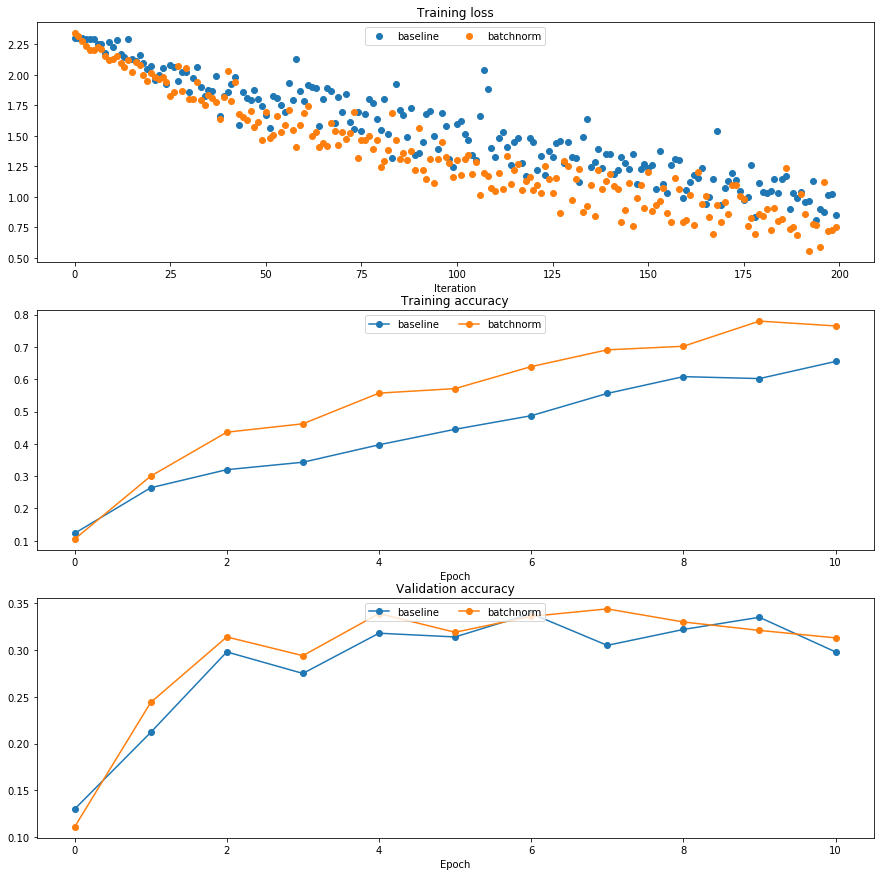

In [19]:
plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')
plt.plot(solver.loss_history, 'o', label='baseline')
plt.plot(bn_solver.loss_history, 'o', label='batchnorm')
plt.legend(loc='upper center', ncol=4)


plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')
plt.plot(solver.train_acc_history, '-o', label='baseline')
plt.plot(bn_solver.train_acc_history, '-o', label='batchnorm')
plt.legend(loc='upper center', ncol=4)

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')
plt.plot(solver.val_acc_history, '-o', label='baseline')
plt.plot(bn_solver.val_acc_history, '-o', label='batchnorm')
plt.legend(loc='upper center', ncol=4)

plt.gcf().set_size_inches(15, 15)
plt.show()

## Batch normalization and initialization
We will now run a small experiment to study the interaction of batch normalization and weight initialization.

The first cell will train 8-layer networks both with and without batch normalization using different scales for weight initialization. The second layer will plot training accuracy, validation set accuracy, and training loss as a function of the weight initialization scale.

In [20]:
np.random.seed(231)
# Try training a very deep net with batchnorm
hidden_dims = [50, 50, 50, 50, 50, 50, 50]

num_train = 1000
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

bn_solvers = {}
solvers = {}
weight_scales = np.logspace(-4, 0, num=10)

for i, weight_scale in enumerate(weight_scales):
    print('Running weight scale %d / %d' % (i + 1, len(weight_scales)))
    bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

    bn_solver = Solver(bn_model, small_data,
                       num_epochs=10, batch_size=50,
                       update_rule='adam',
                       optim_config={
                           'learning_rate': 1e-3,
                       },
                       verbose=False, print_every=200)
    bn_solver.train()
    bn_solvers[weight_scale] = bn_solver
    
    solver = Solver(model, small_data,
                    num_epochs=10, batch_size=50,
                    update_rule='adam',
                    optim_config={
                        'learning_rate': 1e-3,
                    },
                    verbose=False, print_every=200)
    solver.train()
    solvers[weight_scale] = solver

Running weight scale 1 / 10
Running weight scale 2 / 10
Running weight scale 3 / 10
Running weight scale 4 / 10
Running weight scale 5 / 10
Running weight scale 6 / 10
Running weight scale 7 / 10
Running weight scale 8 / 10
Running weight scale 9 / 10
Running weight scale 10 / 10


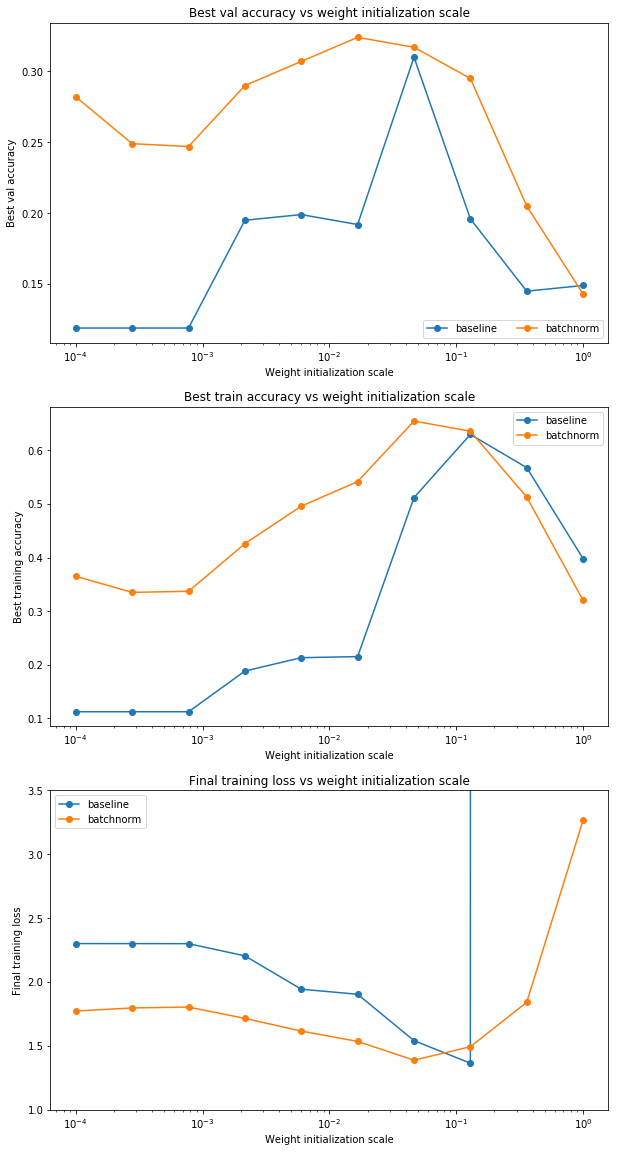

In [21]:
# Plot results of weight scale experiment
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
    best_train_accs.append(max(solvers[ws].train_acc_history))
    bn_best_train_accs.append(max(bn_solvers[ws].train_acc_history))
    
    best_val_accs.append(max(solvers[ws].val_acc_history))
    bn_best_val_accs.append(max(bn_solvers[ws].val_acc_history))
    
    final_train_loss.append(np.mean(solvers[ws].loss_history[-100:]))
    bn_final_train_loss.append(np.mean(bn_solvers[ws].loss_history[-100:]))

plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()
plt.gca().set_ylim(1.0, 3.5)

plt.gcf().set_size_inches(10, 20)
plt.show()

# Learning Rate Decay Over Time
- **Idea:** Start with rather large `learning_rate`, and then decrease it gradually during training process.

## How to decrease
- **Step decay:** decay learning rate every few epochs.
- **Exponential decay:**

### $$\alpha = \alpha_0 e^{-kt}$$

- **1/t decay:**

### $$\alpha = \frac{\alpha_0}{1 + kt}$$

# Update Rules
- So far we have used vanilla stochastic gradient descent (SGD) as our update rule.
- More sophisticated update rules can make it easier to train deep networks. 
- We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

<img src="http://www.snrazavi.ir/imgs/09-Different_update_rules.gif" width="40%"/>

## SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

<img src="http://www.snrazavi.ir/imgs/09-SGD_problem1.jpg" width="100%"/>

**Problem:**
- Loss function is steep vertically; but shallow horizontaly.

<img src="http://www.snrazavi.ir/imgs/09-SGD_problem2.jpg" width="100%"/>

### Momentum

<img src="http://www.snrazavi.ir/imgs/09-momentum.jpg" width="80%"/>

running with  sgd
(Iteration    1 /  200) loss: 2.758048
(Epoch  0 /  5) train acc: 0.116000; val_acc: 0.124000
(Iteration   11 /  200) loss: 2.186369
(Iteration   21 /  200) loss: 2.114282
(Iteration   31 /  200) loss: 2.210955
(Epoch  1 /  5) train acc: 0.306000; val_acc: 0.272000
(Iteration   41 /  200) loss: 1.940103
(Iteration   51 /  200) loss: 2.000436
(Iteration   61 /  200) loss: 1.958196
(Iteration   71 /  200) loss: 1.917792
(Epoch  2 /  5) train acc: 0.352000; val_acc: 0.285000
(Iteration   81 /  200) loss: 2.041570
(Iteration   91 /  200) loss: 1.797989
(Iteration  101 /  200) loss: 1.861376
(Iteration  111 /  200) loss: 1.616947
(Epoch  3 /  5) train acc: 0.367000; val_acc: 0.312000
(Iteration  121 /  200) loss: 1.761945
(Iteration  131 /  200) loss: 1.704004
(Iteration  141 /  200) loss: 1.870765
(Iteration  151 /  200) loss: 1.646064
(Epoch  4 /  5) train acc: 0.417000; val_acc: 0.324000
(Iteration  161 /  200) loss: 1.637829
(Iteration  171 /  200) loss: 1.599077
(Iter

C:\Users\Razavi\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


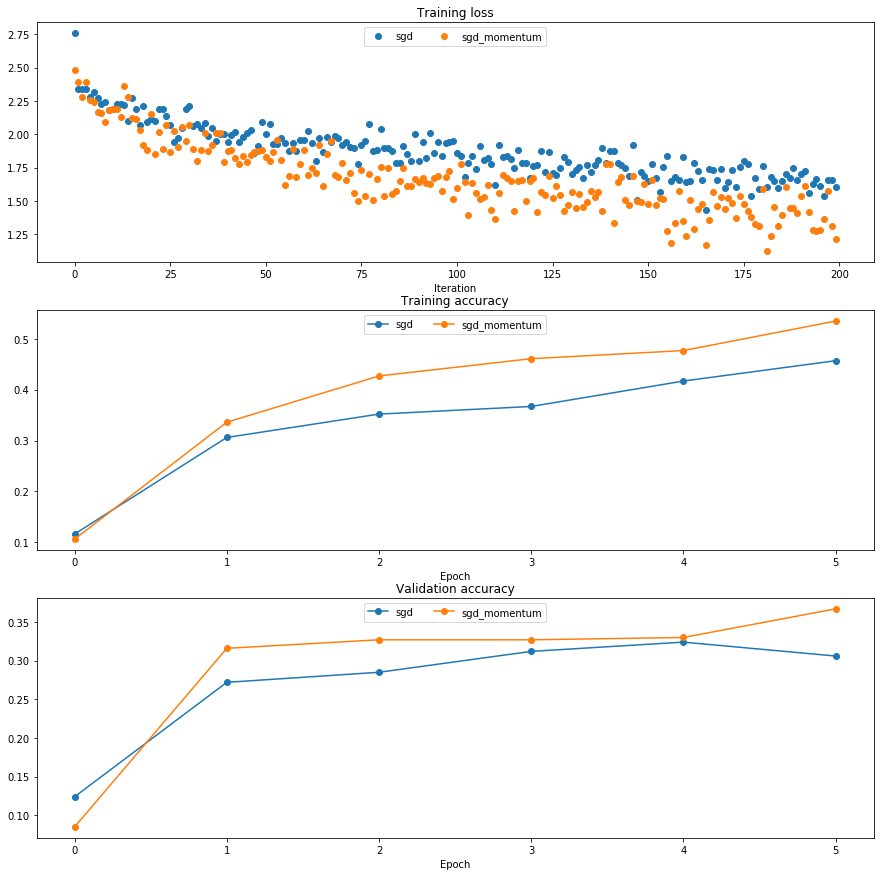

In [22]:
num_train = 4000

small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val'  : data['X_val'],
  'y_val'  : data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)
    
    solver = Solver(model, small_data,
                    num_epochs=5, batch_size=100,
                    update_rule=update_rule,
                    optim_config={
                        'learning_rate': 1e-2,
                    },
                    verbose=True)
    
    solvers[update_rule] = solver
    solver.train()
    print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)
    
    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)
    
    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)
    
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
    
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
**RMSProp** and **Adam** are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

running with  adam
(Iteration    1 /  200) loss: 2.610279
(Epoch  0 /  5) train acc: 0.091000; val_acc: 0.125000
(Iteration   11 /  200) loss: 2.253684
(Iteration   21 /  200) loss: 2.061638
(Iteration   31 /  200) loss: 1.973379
(Epoch  1 /  5) train acc: 0.371000; val_acc: 0.303000
(Iteration   41 /  200) loss: 1.657986
(Iteration   51 /  200) loss: 1.599580
(Iteration   61 /  200) loss: 1.834893
(Iteration   71 /  200) loss: 1.530907
(Epoch  2 /  5) train acc: 0.423000; val_acc: 0.348000
(Iteration   81 /  200) loss: 1.514817
(Iteration   91 /  200) loss: 1.558255
(Iteration  101 /  200) loss: 1.458472
(Iteration  111 /  200) loss: 1.537282
(Epoch  3 /  5) train acc: 0.525000; val_acc: 0.351000
(Iteration  121 /  200) loss: 1.412435
(Iteration  131 /  200) loss: 1.359296
(Iteration  141 /  200) loss: 1.683398
(Iteration  151 /  200) loss: 1.417051
(Epoch  4 /  5) train acc: 0.567000; val_acc: 0.371000
(Iteration  161 /  200) loss: 1.249846
(Iteration  171 /  200) loss: 1.240299
(Ite

C:\Users\Razavi\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


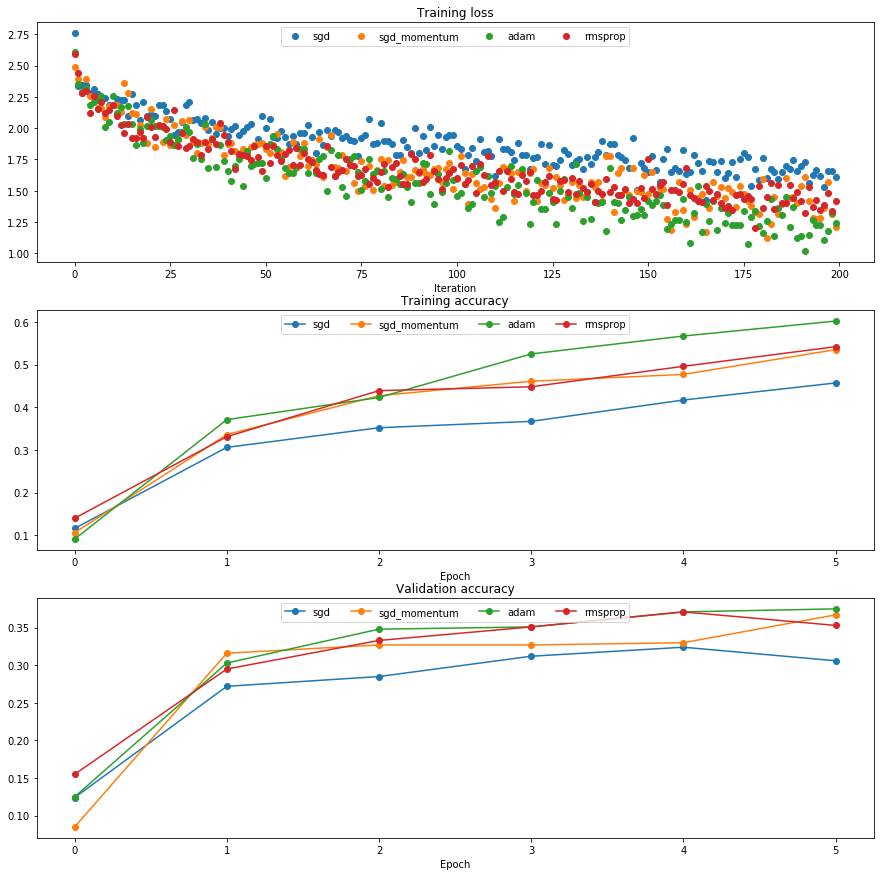

In [23]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)
    
    solver = Solver(model, small_data,
                    num_epochs=5, batch_size=100,
                    update_rule=update_rule,
                    optim_config={
                        'learning_rate': learning_rates[update_rule]
                    },
                    verbose=True)
    solvers[update_rule] = solver
    solver.train()
    print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)
    
    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)
    
    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)
    
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
    
plt.gcf().set_size_inches(15, 15)
plt.show()

# Putting All Together: Train a good model!

In [24]:
model = FullyConnectedNet([250, 250, 250, 250], weight_scale=0.01, dropout=0.25, use_batchnorm=True, reg=1e-5)
solver = Solver(model, data,
                num_epochs=20, 
                batch_size=256,
                update_rule='adam',
                lr_decay=0.95,
                optim_config={
                    'learning_rate': 0.002
                },
#                 checkpoint_name="cifar10_nn",
                verbose=True,
                print_every=5000)
solver.train()

(Iteration    1 / 3820) loss: 2.308043
(Epoch  0 / 20) train acc: 0.140000; val_acc: 0.121000
(Epoch  1 / 20) train acc: 0.446000; val_acc: 0.453000
(Epoch  2 / 20) train acc: 0.506000; val_acc: 0.490000
(Epoch  3 / 20) train acc: 0.550000; val_acc: 0.504000
(Epoch  4 / 20) train acc: 0.534000; val_acc: 0.552000
(Epoch  5 / 20) train acc: 0.560000; val_acc: 0.541000
(Epoch  6 / 20) train acc: 0.580000; val_acc: 0.537000
(Epoch  7 / 20) train acc: 0.586000; val_acc: 0.541000
(Epoch  8 / 20) train acc: 0.613000; val_acc: 0.557000
(Epoch  9 / 20) train acc: 0.630000; val_acc: 0.553000
(Epoch 10 / 20) train acc: 0.650000; val_acc: 0.572000
(Epoch 11 / 20) train acc: 0.641000; val_acc: 0.560000
(Epoch 12 / 20) train acc: 0.665000; val_acc: 0.571000
(Epoch 13 / 20) train acc: 0.690000; val_acc: 0.575000
(Epoch 14 / 20) train acc: 0.673000; val_acc: 0.581000
(Epoch 15 / 20) train acc: 0.684000; val_acc: 0.590000
(Epoch 16 / 20) train acc: 0.709000; val_acc: 0.576000
(Epoch 17 / 20) train acc:

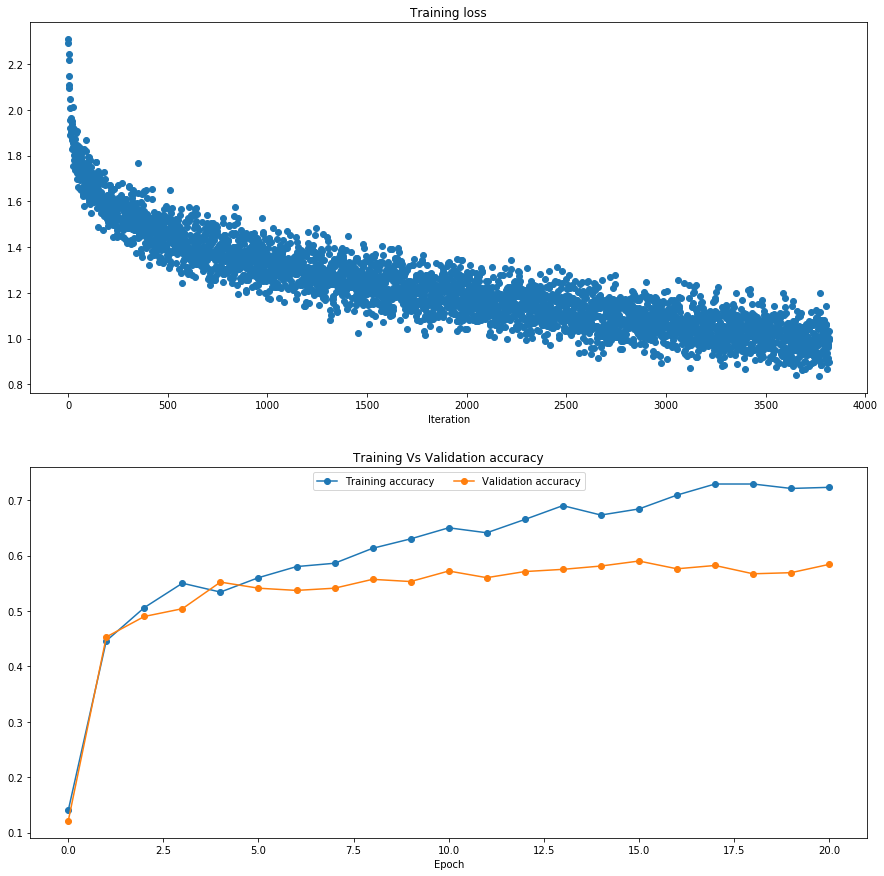

In [25]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o', label='Training accuracy')
plt.plot(solver.val_acc_history, '-o', label='Validation accuracy')
plt.title('Training Vs Validation accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper center', ncol=2)
# plt.grid('on')

plt.gcf().set_size_inches(15, 15)
plt.show()

### Testing the model

In [26]:
y_test_pred = np.argmax(model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.587
Test set accuracy:  0.573


## Loading weights from file

In [27]:
import os, pickle

filename = "cifar10_nn_epoch_20.pkl"
with open(filename, 'rb') as f:
    dic = pickle.load(f)
    print(dic.keys())

dict_keys(['model', 'update_rule', 'lr_decay', 'optim_config', 'batch_size', 'num_train_samples', 'num_val_samples', 'epoch', 'loss_history', 'train_acc_history', 'val_acc_history'])


In [28]:
model = dic['model']
loss_history = dic['loss_history']
train_acc_history = dic['train_acc_history']
val_acc_history = dic['val_acc_history']

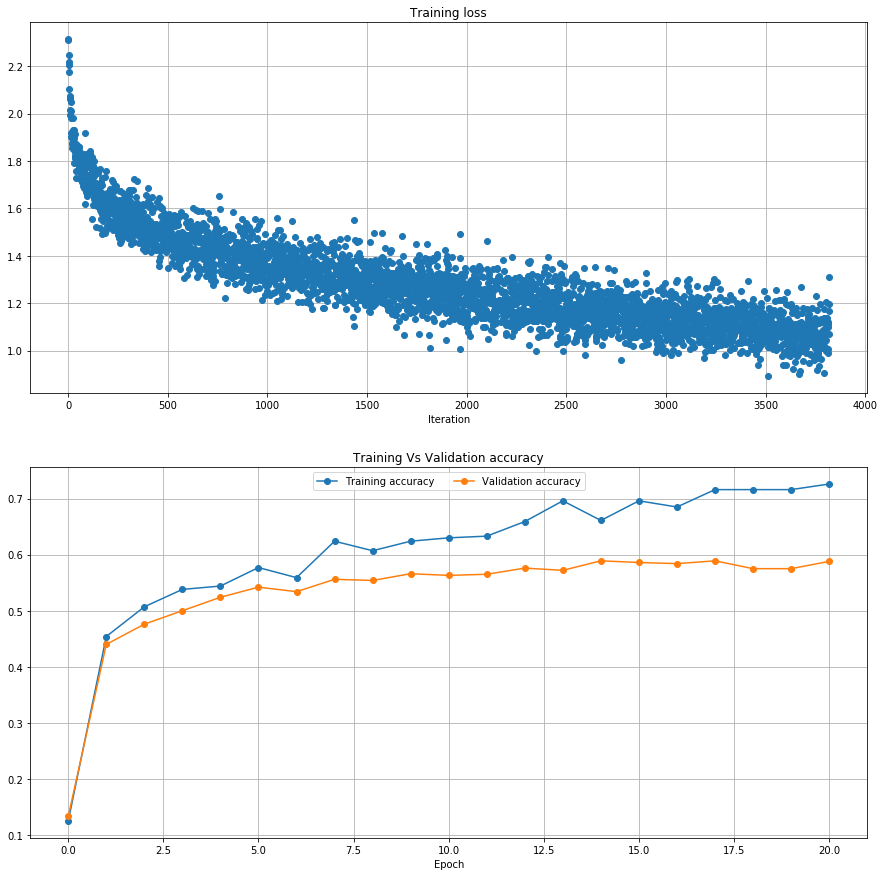

In [29]:
plt.subplot(2, 1, 1)
plt.plot(loss_history, 'o')
plt.title('Training loss')
plt.xlabel('Iteration')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(train_acc_history, '-o', label='Training accuracy')
plt.plot(val_acc_history, '-o', label='Validation accuracy')
plt.title('Training Vs Validation accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper center', ncol=2)
plt.grid(True)

plt.gcf().set_size_inches(15, 15)
plt.show()

In [30]:
y_test_pred = np.argmax(model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.588
Test set accuracy:  0.593


### Testing the loaded model

# Data Augmentation
- A very widely used technique.

**Idea:** 
- Change data (pixels), without changing the label
- Train on transformed data

<img src="http://www.snrazavi.ir/imgs/09-Augmentation.jpg" width="100%"/>

## Horizontal flips

<img src="http://www.snrazavi.ir/imgs/09-flip.jpg" width="50%"/>

## Random Crops

<img src="http://www.snrazavi.ir/imgs/09-crop.jpg" width="55%"/>

## Color jitter

<img src="http://www.snrazavi.ir/imgs/09-color_jitter.jpg" width="55%"/>

### Other ways:
- Translation, rotation, stretching, etc.

<img align="left" src="http://www.snrazavi.ir/imgs/next_week.png" width="25%"/>

# What is next?
 - Convolutional Neural Networks
 - Transfer Learning
 - Introducing a deep learning framework (eg., Keras)
 - Solving a real-world problem (maybe from kaggle!)